### Перевод в SMILES через RDKit на QM9

In [ ]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/gdb9.tar.gz
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv

In [9]:
!tar -xvf ./gdb9.tar.gz

gdb9.sdf.csv
gdb9.sdf


In [1]:

import re
import collections
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds 

In [2]:
import copy

def load_qm9(sdf_path, csv_file_path='./qm9.csv', max_mols=100):
    qm9_csv = pd.read_csv(csv_file_path)
    # max_mols = len(qm9_csv)
    print(max_mols)
    true_smiles_dict = {idx: qm9_csv.iloc[idx]['smiles'] for idx in range(len(qm9_csv))}
    
    suppl = Chem.SDMolSupplier(sdf_path, sanitize=False, removeHs=False)

    mols = []
    invalid_mols = []
    ionized_mols = []
    for idx, mol in enumerate(suppl):
        if idx not in true_smiles_dict or mol is None: continue

        # old_mol = copy.deepcopy(mol)
        try:
            charge = Chem.GetFormalCharge(mol)
            if charge != 0: 
                ionized_mols.append({'id': idx, 'mol': mol, 'smiles' : Chem.MolToSmiles(mol)})
                continue
            rdDetermineBonds.DetermineBonds(mol, charge=charge)
            Chem.Kekulize(mol, clearAromaticFlags=True)
            Chem.SanitizeMol(mol)
        except Exception as e:
            invalid_mols.append({'id': idx, 'mol': mol, 'smiles' : Chem.MolToSmiles(mol)})
            continue
            
        mols.append({            
            'index': idx,
            'mol': mol,
            'old_mol': Chem.AddHs(Chem.MolFromSmiles(qm9_csv.iloc[idx]['smiles'])),
            'true_smiles': qm9_csv.iloc[idx]['smiles']
        })

        if len(mols) >= max_mols: break
        
    print(f'Loaded {len(mols)} valid QM9 molecules with true SMILES')
    return mols, invalid_mols, ionized_mols

In [3]:
def compute_stats(records):
    stats = collections.Counter()
    undetected_mols = []
    for rec in records:
        mol = rec['mol']
        old_mol = rec['old_mol']
        are_same = mol.HasSubstructMatch(old_mol) and old_mol.HasSubstructMatch(mol)
        are_same_smiles = Chem.MolToSmiles(rec['mol'], canonical=True) == Chem.MolToSmiles(rec['old_mol'], canonical=True)
        stats['total'] += 1
        stats["rdkit_ok"] += (int(are_same))
        stats["rdkit_ok_smiles"] += int(are_same_smiles)
        if not are_same: undetected_mols.append({
            'id': rec['index'], 'sdf_mol': rec['old_mol'], 'pred_mol': rec['mol'],
            'sdf_smiles': Chem.MolToSmiles(rec['old_mol'], canonical=True),
            'pred_smiles': Chem.MolToSmiles(rec['mol'], canonical=True)})
        if not are_same_smiles:
            if rec['index'] % 1000:
                print(Chem.MolToSmiles(rec['mol'], canonical=True), '\n',
                      Chem.MolToSmiles(rec['old_mol'], canonical=True), '\n',
                      '#################')


    print(f"Total molecules {stats['total']}")
    print(f"RDKit Isomorphic graphs:{stats['rdkit_ok']/stats['total']:.4f}")
    print(f"RDKit Smiles_comparison: {stats['rdkit_smiles_ok']/stats['total']:.4f}")
    return undetected_mols

In [4]:
qm9_data, invalid_mols, ionized_mols = load_qm9('./gdb9.sdf', './qm9.csv', max_mols=150000)


150000


[05:35:38] Explicit valence for atom # 4 C, 4, is greater than permitted
[05:35:38] Explicit valence for atom # 4 C, 4, is greater than permitted
[05:35:38] Explicit valence for atom # 4 C, 4, is greater than permitted
[05:35:38] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:38] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:38] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 3 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 3 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is greater than permitted
[05:35:39] Explicit valence for atom # 5 C, 4, is g

Loaded 102022 valid QM9 molecules with true SMILES


[05:36:39] Explicit valence for atom # 7 C, 4, is greater than permitted
[05:36:40] Explicit valence for atom # 7 C, 4, is greater than permitted
[05:36:40] Explicit valence for atom # 3 C, 4, is greater than permitted
[05:36:40] Explicit valence for atom # 1 N, 3, is greater than permitted


In [6]:
ionized_mols[:3]

[{'id': 23,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7ceafd8d4c80>,
  'smiles': '[H]CC#C[NH3+]'},
 {'id': 44,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7ceafd8d5e70>,
  'smiles': '[H]C([H])([H])[NH+]1C([H])([H])C1([H])[H]'},
 {'id': 75,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7ceafd8d7920>,
  'smiles': '[H][N-]C(OC([H])([H])[H])C([H])([H])[H]'}]

In [12]:
invalid_mols[:3]

[{'id': 104,
  'mol': <rdkit.Chem.rdchem.Mol at 0x70464518f840>,
  'smiles': '[H]C1([H])[C@]23([H])C([H])([H])[C@]12([H])C3([H])[H]'},
 {'id': 105,
  'mol': <rdkit.Chem.rdchem.Mol at 0x70464518f990>,
  'smiles': '[H]C1([H])C23([H])OC12([H])C3([H])[H]'},
 {'id': 243,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7046451a2ff0>,
  'smiles': '[H][N+]=[C-]([H])OC(=O)C([H])([H])[H]'}]

In [ ]:
len(invalid_mols)

6690

: 

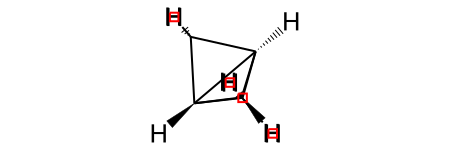

In [19]:
invalid_mols[0]['mol']

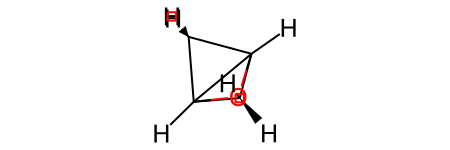

In [20]:
invalid_mols[1]['mol']

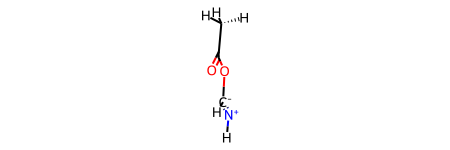

In [21]:
invalid_mols[2]['mol']

In [ ]:
undetected_mols = compute_stats(qm9_data)  

In [24]:
undetected_mols[:3]

[{'id': 79,
  'sdf_mol': <rdkit.Chem.rdchem.Mol at 0x70464518e570>,
  'pred_mol': <rdkit.Chem.rdchem.Mol at 0x70464518e420>,
  'sdf_smiles': '[H]C([H])(C(=O)[O-])[N+]([H])([H])[H]',
  'pred_smiles': '[H]OC(=O)C([H])([H])N([H])[H]'},
 {'id': 112,
  'sdf_mol': <rdkit.Chem.rdchem.Mol at 0x704645190120>,
  'pred_mol': <rdkit.Chem.rdchem.Mol at 0x70464518fed0>,
  'sdf_smiles': '[H]N=C([H])OC([H])=O',
  'pred_smiles': '[H][N-][C+]([H])OC([H])=O'},
 {'id': 184,
  'sdf_mol': <rdkit.Chem.rdchem.Mol at 0x704645193df0>,
  'pred_mol': <rdkit.Chem.rdchem.Mol at 0x704645193d80>,
  'sdf_smiles': '[H]N=c1oc([H])c([H])n1[H]',
  'pred_smiles': '[H][N-]c1oc([H])c([H])[n+]1[H]'}]

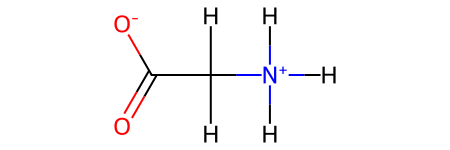

In [25]:
undetected_mols[0]['sdf_mol']

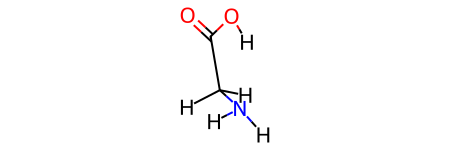

In [26]:
undetected_mols[0]['pred_mol']

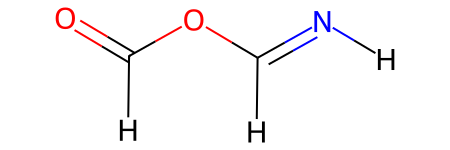

In [27]:
undetected_mols[1]['sdf_mol']

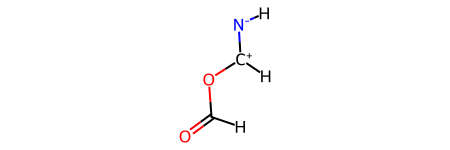

In [28]:
undetected_mols[1]['pred_mol']

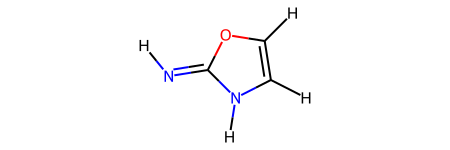

In [29]:
undetected_mols[2]['sdf_mol']

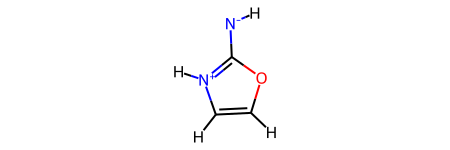

In [30]:
undetected_mols[2]['pred_mol']

In [55]:
qm9_data[10], Chem.MolToSmiles(qm9_data[10]['mol'], canonical=True), Chem.MolToSmiles(qm9_data[10]['old_mol'], canonical=True) 

({'index': 10,
  'mol': <rdkit.Chem.rdchem.Mol at 0x704645a0a2d0>,
  'old_mol': <rdkit.Chem.rdchem.Mol at 0x704645a0ab20>,
  'true_smiles': 'CC=O'},
 '[H]C(=O)C([H])([H])[H]',
 '[H]C(=O)C([H])([H])[H]')

### Генерация датасета

In [4]:
import datasets
import torch
from tqdm import tqdm
import numpy as np

In [ ]:
ALLOWED_ATOM_TYPES = ['C', 'O', 'N', 'F', 'S', 'Cl', 'Br', 'I', 'P']
positions = []
onehot_types = []
bonds = []
names = []
for rec in tqdm(qm9_data):
    
    parsed = datasets.parse_molecule(Chem.RemoveHs(rec['mol']))
    print(parsed)
    positions.append(parsed[0]),
    onehot_types.append(parsed[1]),
    bonds.append(parsed[2][:, :3])
    names.append(rec['true_smiles'])
    

In [43]:
parsed

(array([[-1.2558,  1.4892, -0.5036],
        [-1.3215,  0.0125, -0.0051],
        [-1.2802, -1.4731, -0.479 ],
        [-0.0162, -1.7428,  0.3852],
        [ 1.2642, -1.4934, -0.4607],
        [ 1.3227, -0.0088,  0.0145],
        [ 1.2886,  1.4689, -0.4842],
        [ 0.012 ,  1.7526,  0.3568],
        [-0.0042,  0.0073,  0.6627]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 3, 1, 0

In [25]:
sorted(ALLOWED_ATOM_TYPES)

['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']

In [9]:

data_to_save = []
for pos, typ, bnd, name in zip(positions, onehot_types, bonds, names):
    sample = {
        'name': name,
        'positions': torch.tensor(pos, dtype=torch.float32),
        'atoms': torch.tensor(typ, dtype=torch.float32),
        'bonds': torch.tensor(bnd, dtype=torch.float32)
    }
    data_to_save.append(sample)

# Сохраняем в .pt файл
# save_path = './qm9filtered.pt'
# torch.save(data_to_save, save_path)

In [7]:
dataset = torch.load('../qm9filtered_withHs.pt')


/tmp/ipykernel_678683/3896476526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('../qm9filtered_withHs.pt')


In [ ]:
data_to_save = 

{'name': 'C',
 'positions': tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
         [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
         [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
         [-5.4080e-01,  1.4475e+00, -8.7660e-01],
         [-5.2380e-01,  1.4379e+00,  9.0640e-01]]),
 'atoms': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 'bonds': tensor([[1., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0.],
         [2., 0., 1., 0., 0.],
         [0., 2., 1., 0., 0.],
         [3., 0., 1., 0., 0.],
         [0., 3., 1., 0., 0.],
         [4., 0., 1., 0., 0.],
         [0., 4., 1., 0., 0.]])}

In [8]:
bonddataset = datasets.BondDataset(dataset)

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
dataset = torch.load('../qm9filtered_withHs.pt')
data = bonddataset.preprocess(dataset, device='cuda')

  0%|          | 0/127051 [00:00<?, ?it/s]/home/user12/maslov/datasets.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'one_hot': torch.tensor(one_hot, dtype=const.TORCH_FLOAT, device=device),
/home/user12/maslov/datasets.py:300: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'positions': torch.tensor(positions, dtype=const.TORCH_FLOAT, device=device),
100%|██████████| 127051/127051 [17:54<00:00, 118.28it/s]


In [11]:
datasets.BondDataset(data, save_path='../qm9filtered_withHs_processed.pt')

Saving dataset as ../qm9filtered_withHs_processed.pt


In [16]:
data[4]

{'name': 'C#N',
 'one_hot': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 'positions': tensor([[-1.3300e-02,  1.1325e+00,  8.3000e-03],
         [ 2.3000e-03, -1.9200e-02,  1.9000e-03],
         [-2.7800e-02,  2.1989e+00,  1.4200e-02]], device='cuda:0'),
 'edge_index': tensor([[0, 1],
         [0, 2],
         [1, 0],
         [1, 2],
         [2, 0],
         [2, 1]], device='cuda:0', dtype=torch.int8),
 'edge_attr': tensor([[1.1518],
         [1.0665],
         [1.1518],
         [2.2183],
         [1.0665],
         [2.2183]], device='cuda:0'),
 'bond_orders': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]

In [28]:
data_geom = torch.load('./datasets/geom_train.pt')

/tmp/ipykernel_523639/3707843292.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_geom = torch.load('./datasets/geom_train.pt')


In [55]:
data_geom[0]

{'name': 'CC(Oc1ccc(Cl)cc1)C(=O)Nc1ncccn1',
 'one_hot': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0'),
 'positions': tensor([[-1.7910, -

In [34]:
data[0]

{'name': 'C',
 'one_hot': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0'),
 'positions': tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
         [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
         [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
         [-5.4080e-01,  1.4475e+00, -8.7660e-01],
         [-5.2380e-01,  1.4379e+00,  9.0640e-01]], device='cuda:0'),
 'edge_index': tensor([[0, 1],
         [0, 2],
         [0, 3],
         [0, 4],
         [1, 0],
         [1, 2],
         [1, 3],
         [1, 4],
         [2, 0],
         [2, 1],
         [2, 3],
         [2, 4],
         [3, 0],
         [3, 1],
         [3, 2],
         [3, 4],
         [4, 0],
         [4, 1],
         [4, 2],
         [4, 3]], device='cuda:0', dtype=torch.int8),
 'edge_attr': tensor([[1.0919],
         [1.0919

In [21]:
bonddataset = datasets.BondDataset(data, save_path='../qm9filtered_processed.pt')

Saving dataset as ../qm9filtered_processed.pt


In [31]:
dataset = torch.load('./qm9filtered_processed.pt')

In [37]:
np.array([el[:, 7].sum() for el in bonds]).sum()

np.int64(0)

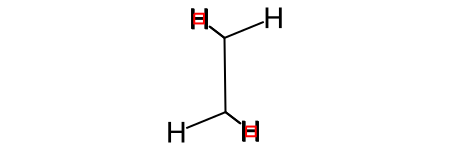

In [64]:
qm9_data[6]['mol']